<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Iteration4_UncertaintyRangeExp_LoanPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Range Experiment
- Dataset : LoanPredict
- Model : RandomForestClassifier
- Reference Dataset : 2010년 (11497, 81)
- Inference Dataset : 2011년 ~ 2018년 (1,323,732, 1)

# 1 구글 드라이브 연결

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 함수 선언



In [2]:
#@title
# 노이즈를 추가하는 함수 선언
import numpy as np
import random
def random_sample(inp):
    data_len = len(inp)
    exp_data_len = int(data_len/exp_model_param["split_ratio"])

    if exp_model_param["ramdom_sample_block"] and exp_model_param["split_ratio"]!=1:
        random_index = np.random.randint(0, data_len-exp_data_len)
        random_index = np.arange(random_index, random_index+exp_data_len)
    else:
        random_index = np.random.permutation(data_len)
        random_index = random_index[:exp_data_len]
    return random_index


def random_sigma_add(x_inf_d):
    df_state = pd.DataFrame({"mean":np.mean(x_train,axis=0),"std":np.std(x_train,axis=0)})
    permutaion_sigma = random.uniform(exp_model_param["sigma"][0], exp_model_param["sigma"][1])

    #permutation for x_inf_d
    p1 = random.random()
    nums = np.random.choice([0, 1], size=x_inf_d.shape[0], p=[1-p1, p1])
    v = random.choice(range(x_inf_d.shape[1]))

    for v in range(x_inf_d.shape[1]):
        x_inf_d[:,v] = x_inf_d[:,v] + np.random.normal(0, df_state['std'][v]*permutaion_sigma, x_inf_d.shape[0])*nums

    return x_inf_d

def add_drirft_data():
    temp_X = []
    temp_Y = []
    for _ in range(exp_model_param["exp_num"][0]):
        sample_idx = random_sample(x_train)
        temp_X.append(random_sigma_add(x_train[sample_idx]))
        temp_Y.append(train_gt[sample_idx])
    return temp_X, temp_Y

In [3]:
#@title
# Uncertainty 설정
from scipy.stats import ks_2samp, entropy
def uncertainty_drift_checker(train, live, evals=100):
    if model_type == "Classification":
        d_value, p_vale = ks_2samp(entropy(train, axis=-1), entropy(live, axis=-1))

    elif model_type == "Regression":
        train_copy = np.concatenate([train for _ in range(evals)], axis=-1)
        test_copy = np.concatenate([live for _ in range(evals)], axis=-1)
        train_std = np.std(train_copy, axis=-1)
        live_std = np.std(test_copy, axis=-1)
        d_value, p_vale = ks_2samp(train_std, live_std)

    return d_value, p_vale

#3 데이터 전처리 및 모델학습

## 3-2 사용할 데이터

In [7]:
#@title
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#@title
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

#@title
def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value


def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

### ★ 수정부분

In [8]:
################################################################################################
#사용할 데이터 입력 할 곳
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)
mi_scores = make_mi_scores(X3, y3, discrete_features="auto")
print(mi_scores)
################################################################################################

x3    0.202783
x2    0.134082
z0    0.091439
x1    0.079411
x0    0.050887
Name: MI Scores, dtype: float64


In [9]:
###########################################
train_size = 10000
test_size = 1000
live_size = 2000

x_train = X3.values[:train_size]
y_train_gt = y3[:train_size].reshape(-1,1)

x_test = X3[train_size:train_size+test_size].values
y_test_gt = y3[:train_size:train_size+test_size].reshape(-1,1)

x_live = X3[train_size+test_size:].values
y_live_gt = y3[train_size+test_size:].reshape(-1,1)

print(x_train.shape, x_test.shape, x_live.shape)
###########################################

(10000, 5) (1000, 5) (29000, 5)


In [10]:
### fit model ###
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=6).fit(x_train, y_train_gt)

<ipython-input-10-ea75c690d485>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(max_depth=6).fit(x_train, y_train_gt)


#4 Experiment 실험

In [11]:
# 실험 모델 환경 설정
import sklearn.metrics as metrics
def acc_fn(y, predict):
    return metrics.accuracy_score(y, predict)*100


def f1_fn(y, predict):
    return metrics.f1_score(y, predict)


exp_model_param = {
    "exp_num":[100],#,5000,10000],
    "split_ratio": 10,
    "sigma":[0,3],
    "ramdom_sample_block":False,
    "metric":["acc", "f1"],
    "metric_threshold":[[5,15], [0.05, 0.15]],
    "metric_fn":[acc_fn, f1_fn]
    }

In [12]:
# 사용할 데이터 및 모델 설정
predict_fn = model.predict_proba
model_type = 'Classification'

y_train = predict_fn(x_train)
train_gt = y_train_gt

In [13]:
import warnings
warnings.filterwarnings(action='ignore')

for _ in enumerate(exp_model_param["exp_num"]):
    exp_X_list, exp_y_list = add_drirft_data()

result_d_value = []
result_score = []
for idx in range(len(exp_X_list)):
  exp_y_train = exp_y_list[idx]
  exp_predict = predict_fn(exp_X_list[idx])
  exp_predict_tmp = predict_fn(exp_X_list[idx])

  # 설정한 Metric을 기반으로 Score 계산
  exp_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if exp_predict_tmp.shape[1] != 1:
          exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
      exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))
  result_score.append(exp_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(y_train, exp_predict)
  result_d_value.append(d_value)

## 4-2 사용할 데이터

In [17]:
# 실험
acc_list = []
f1_list = []
live_d_value = []
fix_x = model.predict_proba(x_train)

data_len = live_size
temp_X = x_live
temp_Y = y_live_gt

# data_len = int(temp_X.shape[0]/100)
# for i in range(0, 97):
for i in range(int(temp_X.shape[0]/live_size)):
  start = data_len*i
  end = data_len*(i+1)
  if i % 10 == 0:
    print((i+1), start, end)

  live_x = temp_X[start:end]
  live_y = model.predict_proba(temp_X[start:end])
  live_gt = temp_Y[start:end]

  d_value, _ = uncertainty_drift_checker(fix_x, live_y)
  acc_list.append(acc_fn(live_gt, np.argmax(live_y, axis=1)))
  f1_list.append(f1_fn(live_gt, np.argmax(live_y, axis=1)))

  live_d_value.append(d_value)

live_score_list = [acc_list, f1_list]

1 0 2000
11 20000 22000


#5 실험결과 출력

## 5-2 사용할 데이터 결과

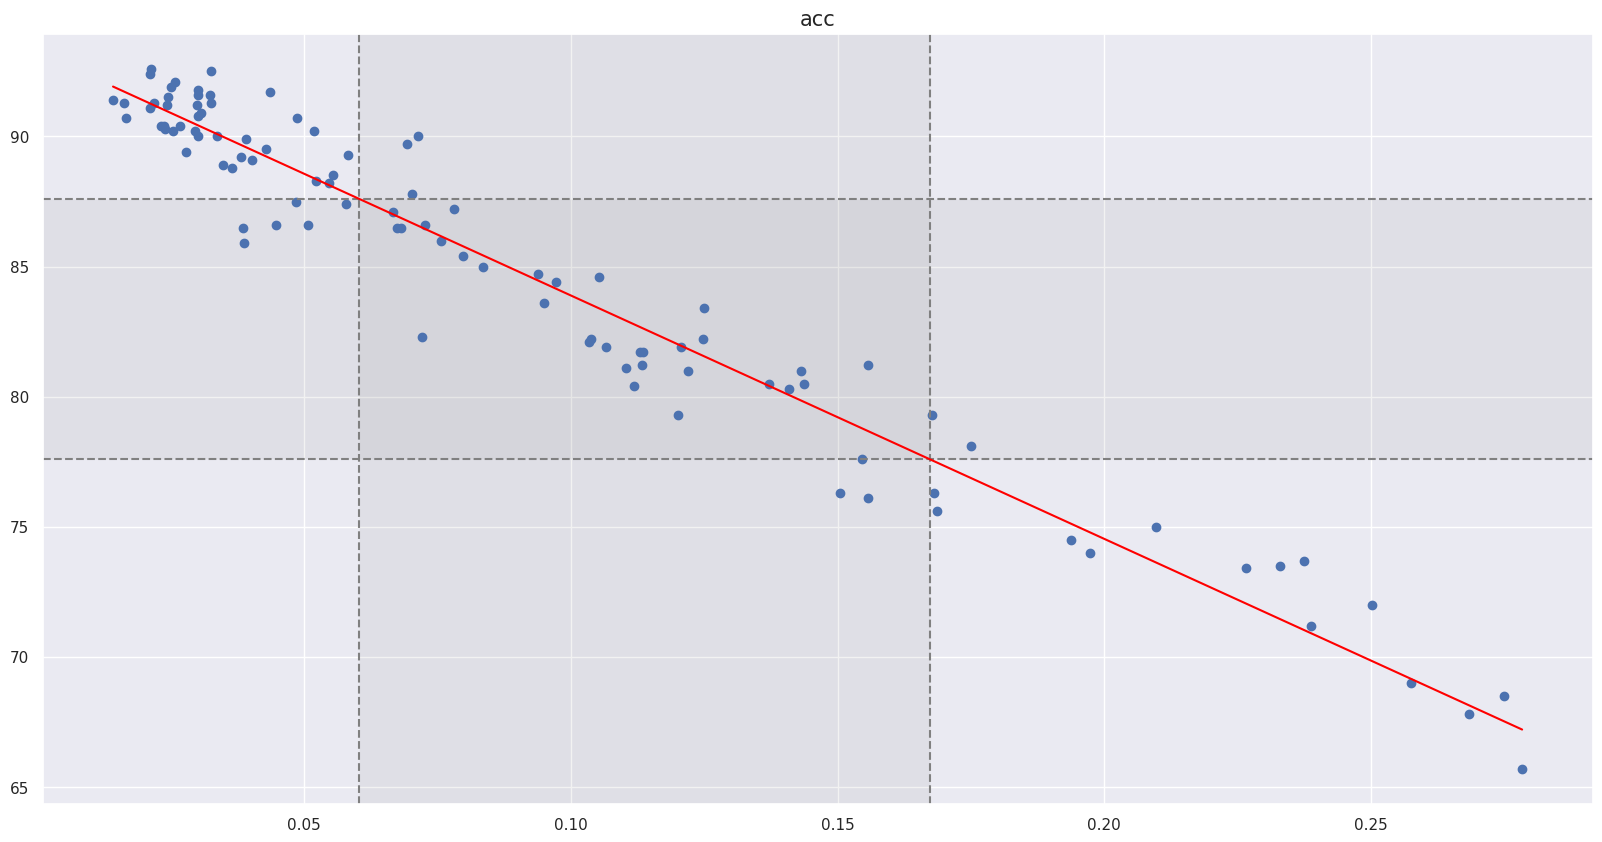

score : 87.60 ~ 77.60
d_val threshold : 0.06 ~ 0.17



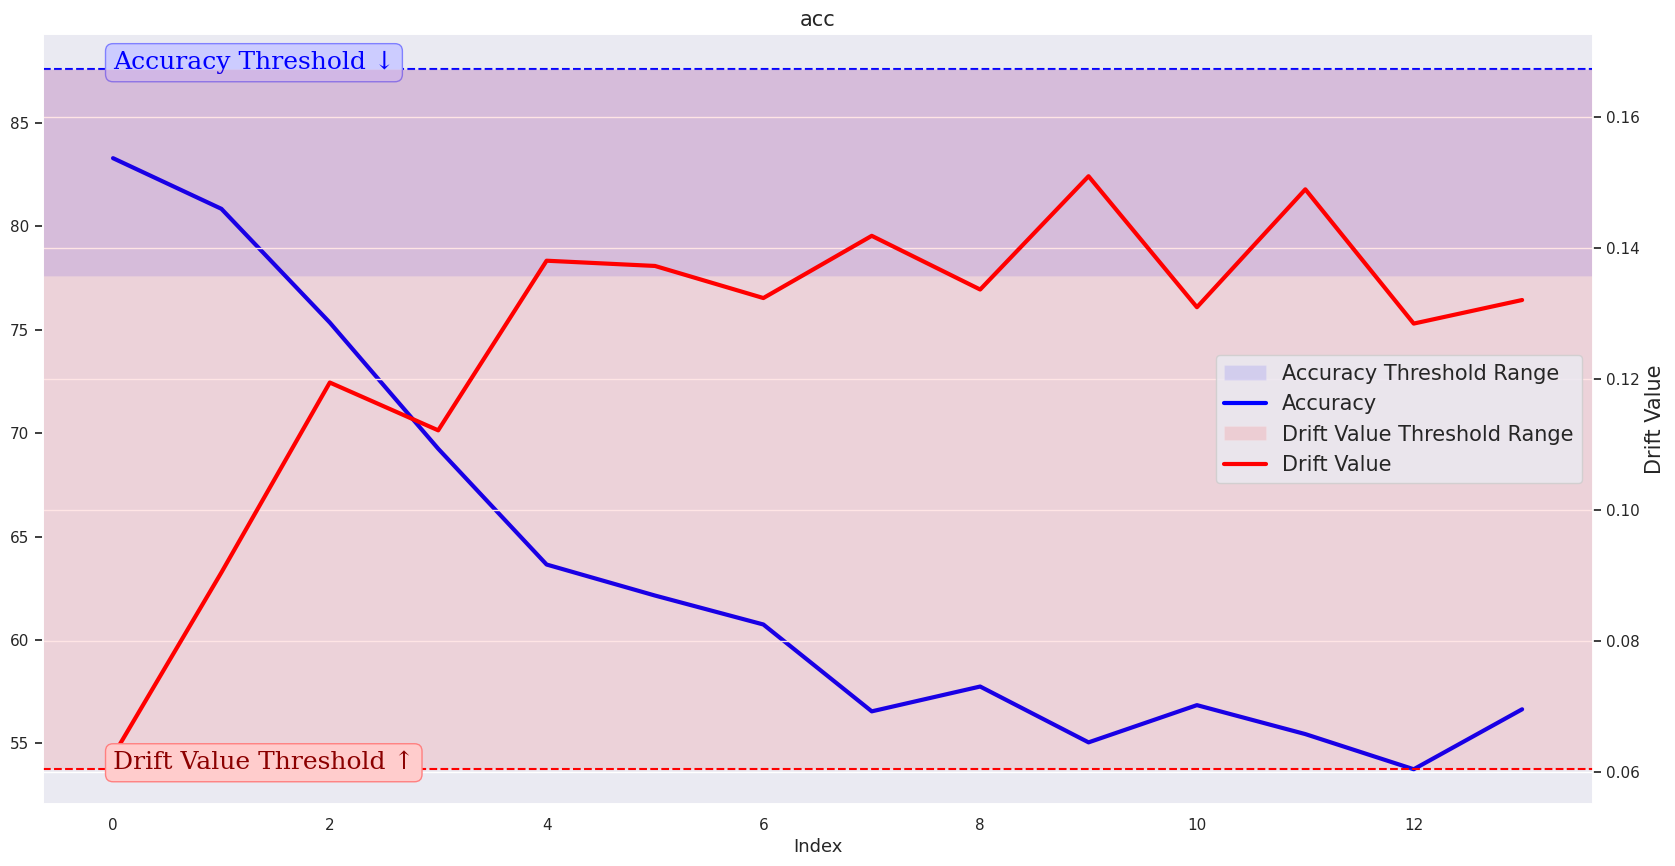

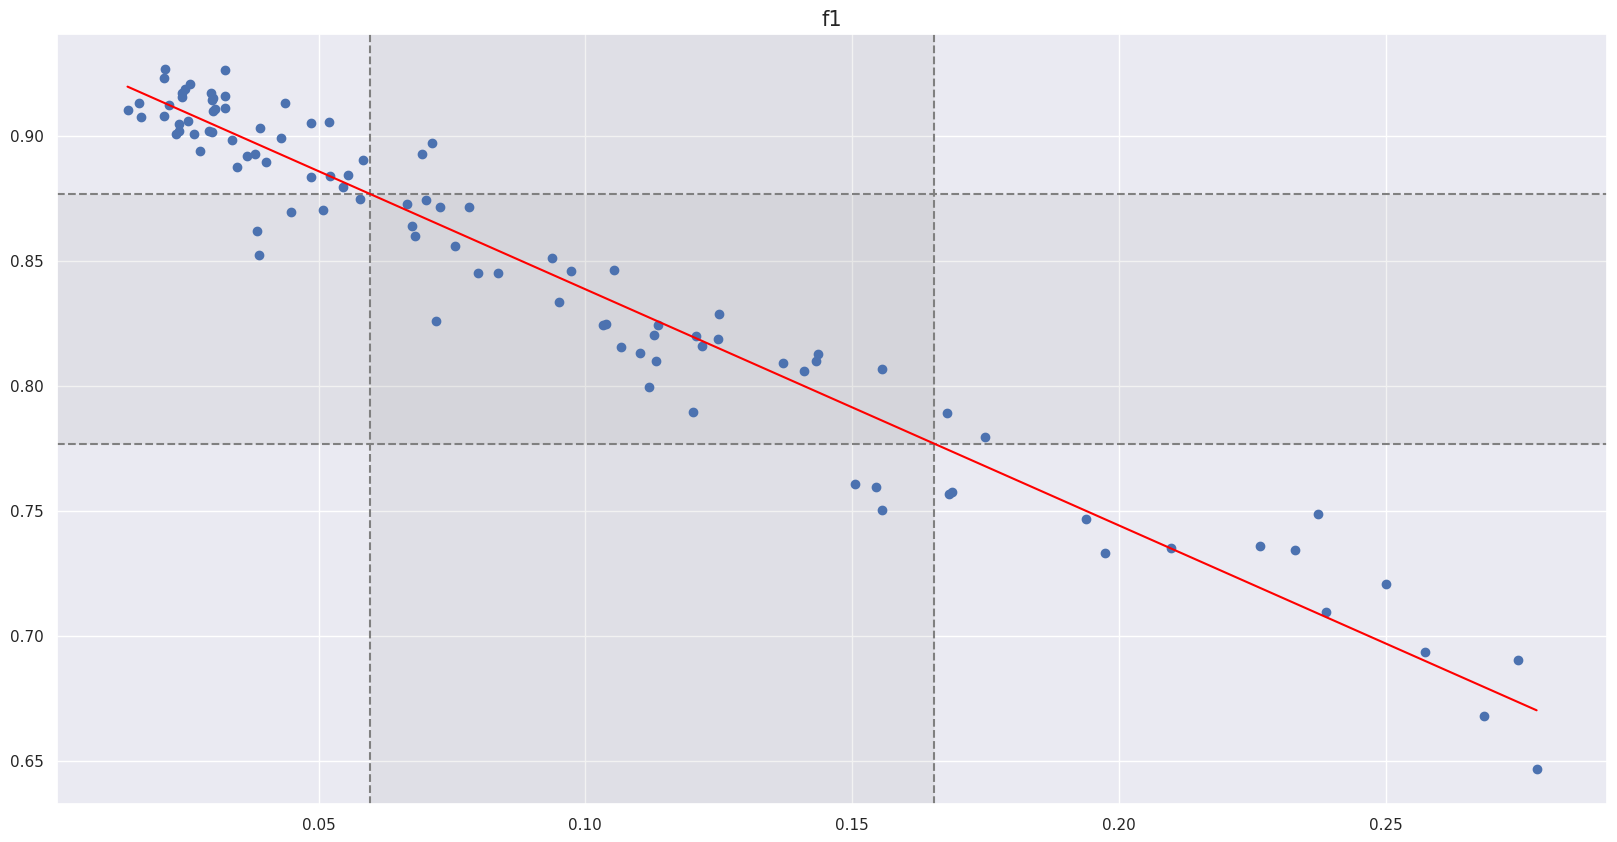

score : 0.88 ~ 0.78
d_val threshold : 0.06 ~ 0.17



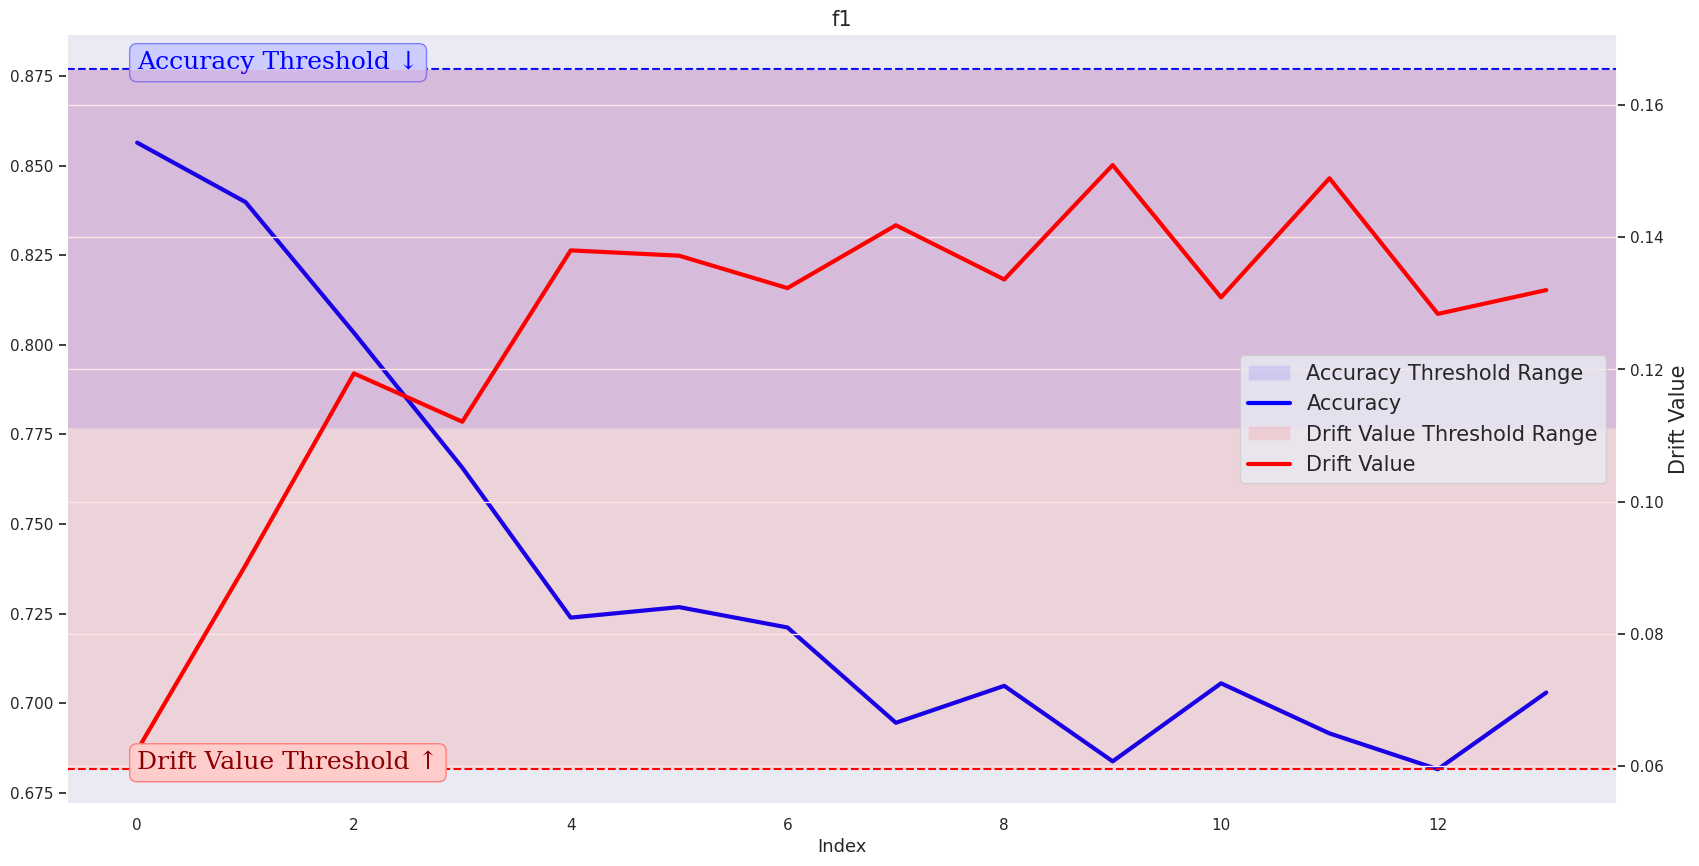

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

font1 = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18}

font2 = {'family': 'serif',
        'color':  'blue',
        'weight': 'normal',
        'size': 18}

box1 = {'boxstyle': 'round',
        'ec': (1.0, 0.5, 0.5),
        'fc': (1.0, 0.8, 0.8)}

box2 = {'boxstyle': 'round',
        'ec': (0.5, 0.5, 1.0),
        'fc': (0.8, 0.8, 1.0)}


line_x = np.asarray(result_d_value)
for i in range(len(exp_model_param['metric'])):
    temp_result = [t[i] for t in result_score]
    line_y = np.asarray(temp_result)

    x_train, _, y_train, _ = train_test_split(line_x, line_y, test_size=0.3, random_state=50)
    lr = LinearRegression()
    lr.fit(x_train.reshape(-1,1), y_train) # train 데이터 학습
    f = lambda x: (lr.coef_ * x) + lr.intercept_
    f_i = lambda y: (y - lr.intercept_) / lr.coef_
    x = np.array([min(x_train), max(x_train)])

    x_dot = x
    y_dot = f(x)
    metric_threshold = []
    for temp_th in exp_model_param["metric_threshold"][i]:
      metric_threshold.append(max(temp_result) - temp_th)
    d_value_threhold = np.round(f_i(metric_threshold)[0], 3)

    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.set_title(exp_model_param['metric'][i], fontsize=15)
    plt.axhspan(metric_threshold[0], metric_threshold[1], facecolor='gray', alpha = 0.1)
    plt.axvspan(f_i(metric_threshold[0])[0], f_i(metric_threshold[1])[0], facecolor='gray', alpha = 0.1)
    plt.axhline(metric_threshold[0], color = "gray", linestyle="--")
    plt.axhline(metric_threshold[1], color = "gray", linestyle="--")
    plt.axvline(f_i(metric_threshold[0]), color = "gray", linestyle="--")
    plt.axvline(f_i(metric_threshold[1]), color = "gray", linestyle="--")
    plt.plot(x, f(x), color = "red")
    plt.scatter(result_d_value, temp_result)
    plt.show()
    print('score : %.2f ~ %.2f' % (metric_threshold[0], metric_threshold[1]))
    print('d_val threshold : %.2f ~ %.2f' % (f_i(metric_threshold[0]), f_i(metric_threshold[1])))
    print()

    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.set_title(exp_model_param['metric'][i], fontsize=15)
    ax1.axhspan(metric_threshold[0], metric_threshold[1], facecolor='blue', alpha = 0.1, label = 'Accuracy Threshold Range')
    ax1.axhline(metric_threshold[0], color = "blue", linestyle="--")
    ax1.plot(live_score_list[i], color = 'blue', label='Accuracy', linewidth=3)
    ax1.text(0, metric_threshold[0], 'Accuracy Threshold ↓', fontdict=font2, bbox=box2)
    ax1.set_xlabel("Index",fontsize=13)
    ax1.grid()

    ax2 = ax1.twinx()
    ax2.set_ylabel("Drift Value", fontsize=15)
    ax2.axhspan(f_i(metric_threshold[0])[0], f_i(metric_threshold[1])[0], facecolor='red', alpha = 0.1, label = 'Drift Value Threshold Range')
    ax2.axhline(f_i(metric_threshold[0]), color = "red", linestyle="--")
    ax2.plot(live_d_value, color = 'red', label='Drift Value', linewidth=3)
    ax2.text(0, f_i(metric_threshold[0]), 'Drift Value Threshold ↑', fontdict=font1, bbox=box1)

    h,l = ax1.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    plt.legend(h+h2,l+l2,loc=0 , prop={'size':15})
    plt.show()
    print()

## Case #1 MI의 감소, Drift의 증가

In [20]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

seed_everything()

y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(0,cor_,data_size)

seed_everything(100)

for i in range(400):
    s = i*100
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)


columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


### 실험 #1

In [21]:
# Normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:1800])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X[0:1800], y[0:1800])


In [22]:
###########################################
train_size = 1800
test_size = 200
live_size = 400

x_train = X.values[:train_size]
y_train_gt = y[:train_size].reshape(-1,1)

x_test = X[train_size:train_size+test_size].values
y_test_gt = y[:train_size:train_size+test_size].reshape(-1,1)

x_live = X[train_size+test_size:].values
y_live_gt = y[train_size+test_size:].reshape(-1,1)

print(x_train.shape, x_test.shape, x_live.shape)
###########################################

(1800, 5) (200, 5) (38000, 5)


In [23]:
exp_model_param = {
    "exp_num":[100],#,5000,10000],
    "split_ratio": 10,
    "sigma":[0,3],
    "ramdom_sample_block":False,
    "metric":["acc", "f1"],
    "metric_threshold":[[5,15], [0.05, 0.15]],
    "metric_fn":[acc_fn, f1_fn]
    }

# 사용할 데이터 및 모델 설정
predict_fn = model.predict_proba
model_type = 'Classification'

y_train = predict_fn(x_train)
train_gt = y_train_gt

In [24]:

for _ in enumerate(exp_model_param["exp_num"]):
    exp_X_list, exp_y_list = add_drirft_data()


In [25]:

result_d_value = []
result_score = []
for idx in range(len(exp_X_list)):
  exp_y_train = exp_y_list[idx]
  exp_predict = predict_fn(exp_X_list[idx])
  exp_predict_tmp = predict_fn(exp_X_list[idx])

  # 설정한 Metric을 기반으로 Score 계산
  exp_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if exp_predict_tmp.shape[1] != 1:
          exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
      exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))
  result_score.append(exp_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(y_train, exp_predict)
  result_d_value.append(d_value)

result_score = np.asarray(result_score)

In [34]:
bucket_size=400
live_set = [X[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X[2000:].shape[0]/bucket_size))]
live_set_y = [y[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(y[2000:].shape[0]/bucket_size))]


In [43]:
real_scores = []
real_d_value = []
for idx in range(len(live_set)):
  predicted_y = predict_fn(live_set[idx])

  # 설정한 Metric을 기반으로 Score 계산
  real_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if predicted_y.shape[1] != 1:
          predicted_y = np.argmax(predicted_y, axis=1).reshape(-1,1)
      real_score.append(exp_model_param['metric_fn'][i](live_set_y[idx], (predicted_y > 0.5).astype(float)))
  real_scores.append(real_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(live_set_y[idx].reshape(-1,1), predicted_y)
  real_d_value.append(d_value)

real_scores = np.asarray(real_scores)

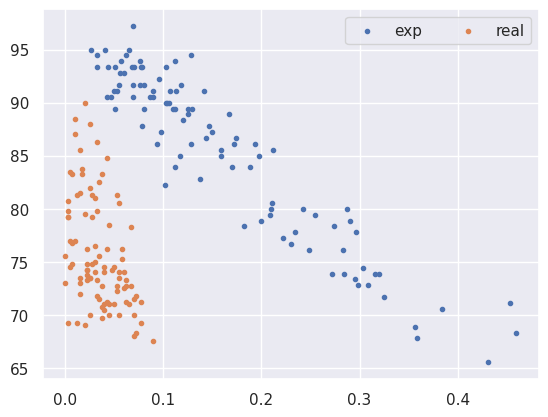

In [54]:
plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
plt.legend(loc=1,ncol=2)
plt.show()

### Case #1 결론
+ 90%를 threshod 라고 가정하면, exp의 경우 d-value 는 약 0.1
+ real의 경우, 0.05 정도
+ 오차 상당함....
+ 흠....

## Case #2 MI의 증감(상대적), Drift의 고정

In [56]:

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)


m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

5
21426
z0    0.123425
x0    0.079212
x1    0.032962
x2    0.008752
x3    0.007456
Name: MI Scores, dtype: float64


In [60]:
X = X1
y = np.asarray(y1)

In [61]:
# Normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:1800])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X[0:1800], y[0:1800])

###########################################
train_size = 1800
test_size = 200
live_size = 400

x_train = X.values[:train_size]
y_train_gt = y[:train_size].reshape(-1,1)

x_test = X[train_size:train_size+test_size].values
y_test_gt = y[:train_size:train_size+test_size].reshape(-1,1)

x_live = X[train_size+test_size:].values
y_live_gt = y[train_size+test_size:].reshape(-1,1)

print(x_train.shape, x_test.shape, x_live.shape)
###########################################

exp_model_param = {
    "exp_num":[100],#,5000,10000],
    "split_ratio": 10,
    "sigma":[0,3],
    "ramdom_sample_block":False,
    "metric":["acc", "f1"],
    "metric_threshold":[[5,15], [0.05, 0.15]],
    "metric_fn":[acc_fn, f1_fn]
    }

# 사용할 데이터 및 모델 설정
predict_fn = model.predict_proba
model_type = 'Classification'

y_train = predict_fn(x_train)
train_gt = y_train_gt

for _ in enumerate(exp_model_param["exp_num"]):
    exp_X_list, exp_y_list = add_drirft_data()


result_d_value = []
result_score = []
for idx in range(len(exp_X_list)):
  exp_y_train = exp_y_list[idx]
  exp_predict = predict_fn(exp_X_list[idx])
  exp_predict_tmp = predict_fn(exp_X_list[idx])

  # 설정한 Metric을 기반으로 Score 계산
  exp_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if exp_predict_tmp.shape[1] != 1:
          exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
      exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))
  result_score.append(exp_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(y_train, exp_predict)
  result_d_value.append(d_value)

result_score = np.asarray(result_score)

bucket_size=400
live_set = [X[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X[2000:].shape[0]/bucket_size))]
live_set_y = [y[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(y[2000:].shape[0]/bucket_size))]

real_scores = []
real_d_value = []
for idx in range(len(live_set)):
  predicted_y = predict_fn(live_set[idx])

  # 설정한 Metric을 기반으로 Score 계산
  real_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if predicted_y.shape[1] != 1:
          predicted_y = np.argmax(predicted_y, axis=1).reshape(-1,1)
      real_score.append(exp_model_param['metric_fn'][i](live_set_y[idx], (predicted_y > 0.5).astype(float)))
  real_scores.append(real_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(live_set_y[idx].reshape(-1,1), predicted_y)
  real_d_value.append(d_value)

real_scores = np.asarray(real_scores)

(1800, 5) (200, 5) (38000, 5)


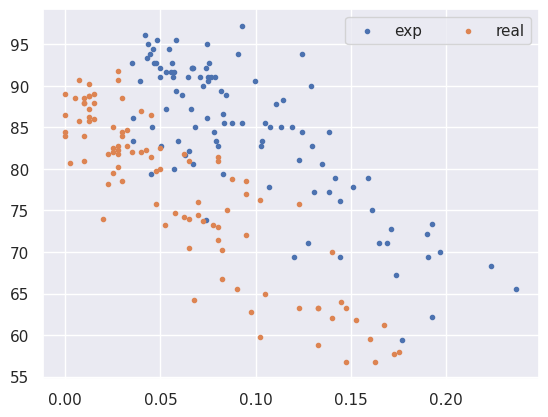

In [62]:
plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
plt.legend(loc=1,ncol=2)
plt.show()

### Case #2 결론
+ 90%를 threshod 라고 가정하면, exp의 경우 d-value 는 약 0.07
+ real의 경우, 0.02~0.03 정도로 추정
+ 오차 상당함....
+ 흠....

## Case #3 MI의 증감(상대적), Drift의 증가

In [63]:

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

m = np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

7.2404412558678075
z0    0.269203
x0    0.077964
x1    0.028502
x2    0.012955
x3    0.001920
Name: MI Scores, dtype: float64


In [64]:
X = X2
y = np.asarray(y2)

In [65]:
# Normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:1800])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X[0:1800], y[0:1800])

###########################################
train_size = 1800
test_size = 200
live_size = 400

x_train = X.values[:train_size]
y_train_gt = y[:train_size].reshape(-1,1)

x_test = X[train_size:train_size+test_size].values
y_test_gt = y[:train_size:train_size+test_size].reshape(-1,1)

x_live = X[train_size+test_size:].values
y_live_gt = y[train_size+test_size:].reshape(-1,1)

print(x_train.shape, x_test.shape, x_live.shape)
###########################################

exp_model_param = {
    "exp_num":[100],#,5000,10000],
    "split_ratio": 10,
    "sigma":[0,3],
    "ramdom_sample_block":False,
    "metric":["acc", "f1"],
    "metric_threshold":[[5,15], [0.05, 0.15]],
    "metric_fn":[acc_fn, f1_fn]
    }

# 사용할 데이터 및 모델 설정
predict_fn = model.predict_proba
model_type = 'Classification'

y_train = predict_fn(x_train)
train_gt = y_train_gt

for _ in enumerate(exp_model_param["exp_num"]):
    exp_X_list, exp_y_list = add_drirft_data()


result_d_value = []
result_score = []
for idx in range(len(exp_X_list)):
  exp_y_train = exp_y_list[idx]
  exp_predict = predict_fn(exp_X_list[idx])
  exp_predict_tmp = predict_fn(exp_X_list[idx])

  # 설정한 Metric을 기반으로 Score 계산
  exp_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if exp_predict_tmp.shape[1] != 1:
          exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
      exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))
  result_score.append(exp_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(y_train, exp_predict)
  result_d_value.append(d_value)

result_score = np.asarray(result_score)

bucket_size=400
live_set = [X[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X[2000:].shape[0]/bucket_size))]
live_set_y = [y[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(y[2000:].shape[0]/bucket_size))]

real_scores = []
real_d_value = []
for idx in range(len(live_set)):
  predicted_y = predict_fn(live_set[idx])

  # 설정한 Metric을 기반으로 Score 계산
  real_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if predicted_y.shape[1] != 1:
          predicted_y = np.argmax(predicted_y, axis=1).reshape(-1,1)
      real_score.append(exp_model_param['metric_fn'][i](live_set_y[idx], (predicted_y > 0.5).astype(float)))
  real_scores.append(real_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(live_set_y[idx].reshape(-1,1), predicted_y)
  real_d_value.append(d_value)

real_scores = np.asarray(real_scores)

(1800, 5) (200, 5) (38000, 5)


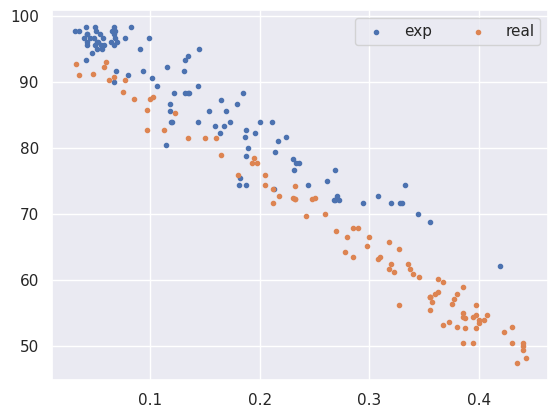

In [66]:
plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
plt.legend(loc=1,ncol=2)
plt.show()

### Case #3 결론
+ 90%를 threshod 라고 가정하면, exp의 경우 d-value 는 약 0.12
+ real의 경우, 0.5 정도로 추정
+ 오차 상당함....
+ 흠....

## Case #4 MI의 고정, Drift의 증가

In [67]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)

columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)
mi_scores = make_mi_scores(X3, y3, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
z0    0.091439
x1    0.079411
x0    0.050887
Name: MI Scores, dtype: float64


In [68]:
X = X3
y = np.asarray(y3)

In [69]:
# Normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:1800])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X[0:1800], y[0:1800])

###########################################
train_size = 1800
test_size = 200
live_size = 400

x_train = X.values[:train_size]
y_train_gt = y[:train_size].reshape(-1,1)

x_test = X[train_size:train_size+test_size].values
y_test_gt = y[:train_size:train_size+test_size].reshape(-1,1)

x_live = X[train_size+test_size:].values
y_live_gt = y[train_size+test_size:].reshape(-1,1)

print(x_train.shape, x_test.shape, x_live.shape)
###########################################

exp_model_param = {
    "exp_num":[100],#,5000,10000],
    "split_ratio": 10,
    "sigma":[0,3],
    "ramdom_sample_block":False,
    "metric":["acc", "f1"],
    "metric_threshold":[[5,15], [0.05, 0.15]],
    "metric_fn":[acc_fn, f1_fn]
    }

# 사용할 데이터 및 모델 설정
predict_fn = model.predict_proba
model_type = 'Classification'

y_train = predict_fn(x_train)
train_gt = y_train_gt

for _ in enumerate(exp_model_param["exp_num"]):
    exp_X_list, exp_y_list = add_drirft_data()


result_d_value = []
result_score = []
for idx in range(len(exp_X_list)):
  exp_y_train = exp_y_list[idx]
  exp_predict = predict_fn(exp_X_list[idx])
  exp_predict_tmp = predict_fn(exp_X_list[idx])

  # 설정한 Metric을 기반으로 Score 계산
  exp_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if exp_predict_tmp.shape[1] != 1:
          exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
      exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))
  result_score.append(exp_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(y_train, exp_predict)
  result_d_value.append(d_value)

result_score = np.asarray(result_score)

bucket_size=400
live_set = [X[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X[2000:].shape[0]/bucket_size))]
live_set_y = [y[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(y[2000:].shape[0]/bucket_size))]

real_scores = []
real_d_value = []
for idx in range(len(live_set)):
  predicted_y = predict_fn(live_set[idx])

  # 설정한 Metric을 기반으로 Score 계산
  real_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if predicted_y.shape[1] != 1:
          predicted_y = np.argmax(predicted_y, axis=1).reshape(-1,1)
      real_score.append(exp_model_param['metric_fn'][i](live_set_y[idx], (predicted_y > 0.5).astype(float)))
  real_scores.append(real_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(live_set_y[idx].reshape(-1,1), predicted_y)
  real_d_value.append(d_value)

real_scores = np.asarray(real_scores)

(1800, 5) (200, 5) (38000, 5)


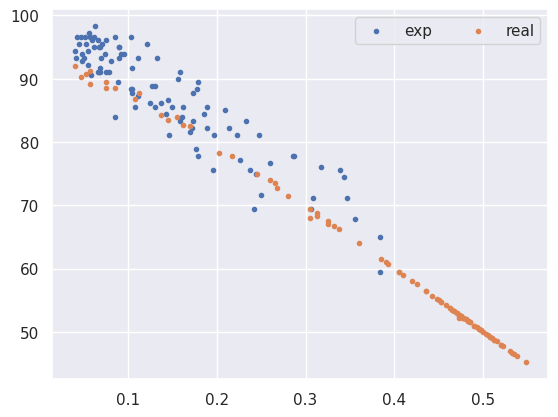

In [70]:
plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
plt.legend(loc=1,ncol=2)
plt.show()

### Case #4 결론
+ 90%를 threshod 라고 가정하면, exp의 경우 d-value 는 약 0.15
+ real의 경우, 0.5 정도로 추정
+ 오차 상당함....
+ 흠....

## Case #5 Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우

In [71]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)
mi_scores = make_mi_scores(X4, y4, discrete_features="auto")
print(mi_scores)

x3    0.145527
x2    0.113997
z0    0.092832
x0    0.043090
x1    0.024980
Name: MI Scores, dtype: float64


In [72]:
X = X4
y = np.asarray(y4)

In [73]:
# Normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:1800])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X[0:1800], y[0:1800])

###########################################
train_size = 1800
test_size = 200
live_size = 400

x_train = X.values[:train_size]
y_train_gt = y[:train_size].reshape(-1,1)

x_test = X[train_size:train_size+test_size].values
y_test_gt = y[:train_size:train_size+test_size].reshape(-1,1)

x_live = X[train_size+test_size:].values
y_live_gt = y[train_size+test_size:].reshape(-1,1)

print(x_train.shape, x_test.shape, x_live.shape)
###########################################

exp_model_param = {
    "exp_num":[100],#,5000,10000],
    "split_ratio": 10,
    "sigma":[0,3],
    "ramdom_sample_block":False,
    "metric":["acc", "f1"],
    "metric_threshold":[[5,15], [0.05, 0.15]],
    "metric_fn":[acc_fn, f1_fn]
    }

# 사용할 데이터 및 모델 설정
predict_fn = model.predict_proba
model_type = 'Classification'

y_train = predict_fn(x_train)
train_gt = y_train_gt

for _ in enumerate(exp_model_param["exp_num"]):
    exp_X_list, exp_y_list = add_drirft_data()


result_d_value = []
result_score = []
for idx in range(len(exp_X_list)):
  exp_y_train = exp_y_list[idx]
  exp_predict = predict_fn(exp_X_list[idx])
  exp_predict_tmp = predict_fn(exp_X_list[idx])

  # 설정한 Metric을 기반으로 Score 계산
  exp_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if exp_predict_tmp.shape[1] != 1:
          exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
      exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))
  result_score.append(exp_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(y_train, exp_predict)
  result_d_value.append(d_value)

result_score = np.asarray(result_score)

bucket_size=400
live_set = [X[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X[2000:].shape[0]/bucket_size))]
live_set_y = [y[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(y[2000:].shape[0]/bucket_size))]

real_scores = []
real_d_value = []
for idx in range(len(live_set)):
  predicted_y = predict_fn(live_set[idx])

  # 설정한 Metric을 기반으로 Score 계산
  real_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if predicted_y.shape[1] != 1:
          predicted_y = np.argmax(predicted_y, axis=1).reshape(-1,1)
      real_score.append(exp_model_param['metric_fn'][i](live_set_y[idx], (predicted_y > 0.5).astype(float)))
  real_scores.append(real_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(live_set_y[idx].reshape(-1,1), predicted_y)
  real_d_value.append(d_value)

real_scores = np.asarray(real_scores)

(1800, 5) (200, 5) (38000, 5)


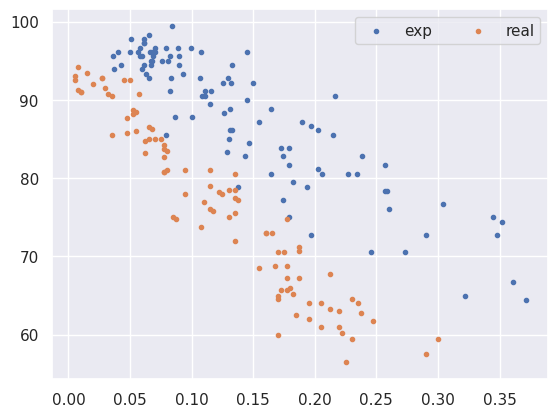

In [74]:
plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
plt.legend(loc=1,ncol=2)
plt.show()

### Case #5 결론
+ 90%를 threshod 라고 가정하면, exp의 경우 d-value 는 약 0.12
+ real의 경우, 0.05 정도로 추정
+ 오차 상당함....
+ 흠....

## Real-world data(Loan data)의 실험

In [75]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


In [76]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted


(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,18000.0,60 months,9.49,B,B2,OWN,130000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260690,88948836,29400.0,60 months,13.99,C,C3,MORTGAGE,180792.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260691,89996426,32000.0,60 months,14.49,C,C4,MORTGAGE,157000.0,Source Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0
2260692,90006534,16000.0,60 months,12.79,C,C1,RENT,150000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,3.0,0.0,N,Cash,N,1


In [78]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

In [79]:

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [80]:

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [81]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries                  0.375380
last_fico_range_high        0.093368
last_pymnt_amnt             0.086047
total_rec_late_fee          0.034615
int_rate                    0.018962
                              ...   
F1                          0.000000
chargeoff_within_12_mths    0.000000
F4                          0.000000
G1                          0.000000
loan_amnt                   0.000000
Name: MI Scores, Length: 81, dtype: float64


In [82]:

# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

In [83]:
top_columns = list(mi_scores[1:6].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term']

In [84]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1]

In [85]:

# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

In [86]:
X = X2
y = np.asarray(Y2)

In [87]:
# Normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:10000])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X[0:10000], y[0:10000])

###########################################
train_size = 10000
test_size = 1147
live_size = 5000

x_train = X.values[:train_size]
y_train_gt = y[:train_size].reshape(-1,1)

x_test = X[train_size:train_size+test_size].values
y_test_gt = y[:train_size:train_size+test_size].reshape(-1,1)

x_live = X[train_size+test_size:].values
y_live_gt = y[train_size+test_size:].reshape(-1,1)

print(x_train.shape, x_test.shape, x_live.shape)
###########################################

exp_model_param = {
    "exp_num":[100],#,5000,10000],
    "split_ratio": 10,
    "sigma":[0,3],
    "ramdom_sample_block":False,
    "metric":["acc", "f1"],
    "metric_threshold":[[5,15], [0.05, 0.15]],
    "metric_fn":[acc_fn, f1_fn]
    }

# 사용할 데이터 및 모델 설정
predict_fn = model.predict_proba
model_type = 'Classification'

y_train = predict_fn(x_train)
train_gt = y_train_gt

for _ in enumerate(exp_model_param["exp_num"]):
    exp_X_list, exp_y_list = add_drirft_data()


result_d_value = []
result_score = []
for idx in range(len(exp_X_list)):
  exp_y_train = exp_y_list[idx]
  exp_predict = predict_fn(exp_X_list[idx])
  exp_predict_tmp = predict_fn(exp_X_list[idx])

  # 설정한 Metric을 기반으로 Score 계산
  exp_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if exp_predict_tmp.shape[1] != 1:
          exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
      exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))
  result_score.append(exp_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(y_train, exp_predict)
  result_d_value.append(d_value)

result_score = np.asarray(result_score)

bucket_size=400
live_set = [X[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X[2000:].shape[0]/bucket_size))]
live_set_y = [y[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(y[2000:].shape[0]/bucket_size))]

real_scores = []
real_d_value = []
for idx in range(len(live_set)):
  predicted_y = predict_fn(live_set[idx])

  # 설정한 Metric을 기반으로 Score 계산
  real_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if predicted_y.shape[1] != 1:
          predicted_y = np.argmax(predicted_y, axis=1).reshape(-1,1)
      real_score.append(exp_model_param['metric_fn'][i](live_set_y[idx], (predicted_y > 0.5).astype(float)))
  real_scores.append(real_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(live_set_y[idx].reshape(-1,1), predicted_y)
  real_d_value.append(d_value)

real_scores = np.asarray(real_scores)

(10000, 5) (1147, 5) (1268533, 5)


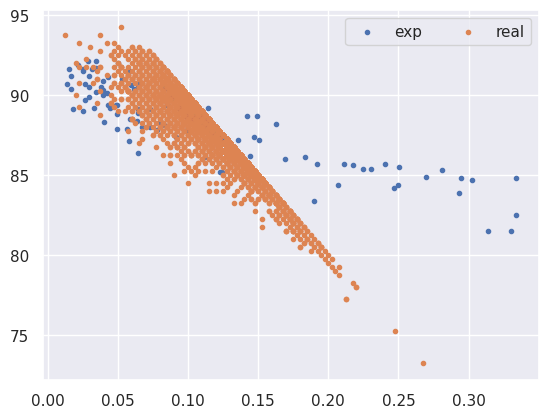

In [88]:
plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
plt.legend(loc=1,ncol=2)
plt.show()

### Case Loan data 결론
+ 90%를 threshod 라고 가정하면, exp의 경우 d-value 는 약 0.05
+ real의 경우, 0.08 정도로 추정
+ 오차가 오히려 적음
+ 흠....뭐지?